In [1]:
#%%writefile ../../src/preprocessing/sbc/make_nudge.py

from netCDF4 import Dataset
from numpy import *
import os
import sys
from scipy.interpolate import NearestNDInterpolator, RegularGridInterpolator
sose_path = os.path.join(os.environ['proj_dir'],'data','preprocessing','external','sose')
sys.path.append(sose_path)
from mds import *
import scipy.io as sio

run = 'waom10_bedmap'

#load roms
print('loading data: roms grid, sose salt and theta, sose grid')
grd_file = os.path.join(os.environ['proj_dir'],'data','preprocessing','processed',run+'_grd.nc')
out_file = os.path.join(os.environ['proj_dir'],'data','preprocessing','processed',run+'_nudge.nc')
sose_path = os.path.join(os.environ['proj_dir'],'data','preprocessing','external','sose')
salt_path = os.path.join(sose_path,'SALT_mnthlyBar')
theta_path = os.path.join(sose_path,'THETA_mnthlyBar')
grid_path = os.path.join(sose_path,'grid.mat')

id = Dataset(grd_file,'r')
zice = id.variables['zice'][:,:]
mask_rho = id.variables["mask_rho"][:,:]
lat_roms = id.variables['lat_rho'][:,:]
lon_roms = id.variables['lon_rho'][:,:]
id.close()

salt_raw = rdmds(salt_path,itrs=100,rec=np.arange(24,36),returnmeta=False,lev=[0],fill_value=NaN)
theta_raw = rdmds(theta_path,itrs=100,rec=np.arange(24,36),returnmeta=False,lev=[0],fill_value=NaN)
sose_grid = sio.loadmat(grid_path)

print('prepare sose data for interpolation')
#apply sose mask to sose data
sose_mask_raw = sose_grid["maskCtrlC"]
sose_mask = tile(swapaxes(sose_mask_raw[:,:,0],0,1),(12,1,1))

salt_ma = ma.masked_where(sose_mask==0.0,salt_raw)
theta_ma = ma.masked_where(sose_mask==0.0,theta_raw)

# load lon and lat sose and change lon to -180 to 180
lon_sose_raw = sose_grid["XC"][:,0]
lon_sose_raw[lon_sose_raw>180] -=360
lat_sose = sose_grid["YC"][0,:]

#reorder lon so it's strictly ascending
lon_order = argsort(lon_sose_raw)
lon_sose_raw = lon_sose_raw[lon_order]

# sose doesnt wrap around, so copy beginning and end
lon_sose_tmp = zeros(size(lon_sose_raw)+2)
lon_sose_tmp[0] = lon_sose_raw[-1]-360
lon_sose_tmp[1:-1] = lon_sose_raw
lon_sose_tmp[-1] = lon_sose_raw[0]+360
lon_sose = lon_sose_tmp.copy()

#reorder and copy sose_data according to lon manipulations
def reorder_sose(data):
    sss_sose_raw = ma.copy(data)
    sss_sose_raw = sss_sose_raw[:,:,lon_order]
    sss_sose_tmp = ma.zeros((size(sss_sose_raw,0),size(sss_sose_raw,1),size(sss_sose_raw,2)+2))
    sss_sose_tmp[:,:,0] = sss_sose_raw[:,:,-1]
    sss_sose_tmp[:,:,1:-1] = sss_sose_raw
    sss_sose_tmp[:,:,-1] = sss_sose_raw[:,:,0]
    sss_sose = sss_sose_tmp.copy()
    return sss_sose

salt = reorder_sose(salt_ma)
theta = reorder_sose(theta_ma)

#interpolate sose to roms grid
print('interpolate sose to roms grid and fill in mask')
def NDinterp(data):
            
    valid_mask = ~np.isnan(data)
    coords = np.array(np.nonzero(valid_mask)).T
    values = data[valid_mask]

    it = NearestNDInterpolator(coords,values)

    filled = it(list(np.ndindex(data.shape))).reshape(data.shape)

    return filled
    

def sose2roms(sose_data,bounds):

    sss_interp = ma.zeros((12,size(lat_roms,0),size(lat_roms,1)))

    for month,A in enumerate(sose_data):

            print("processing month: ",month)
    
            # fill in land mask with nearest neighbours
            print("fill in land mask")
            A[A.mask]=np.nan
            B = NDinterp(A)
            
            #interpolate to roms grid
            print("interpolate to roms grid")
            interp_func = RegularGridInterpolator((lat_sose,lon_sose),A,bounds_error=False, method="linear",fill_value=NaN)
            C = interp_func((lat_roms,lon_roms))

            #fill in far south region
            print("fill in far south")
            D = NDinterp(C)
            
            D[D<bounds[0]]=bounds[0]
            D[D>bounds[1]]=bounds[1]

            sss_interp[month] = D
            
    return sss_interp

salt_it = sose2roms(salt,())
theta_it = sose2roms(theta)

print('set up dQdSST array and time array')
#set up surface net heat flux sensitivity to SST with dQdSST = -40 in takeshi melt season (Nov till Feb)
dQdSST=np.ones(np.shape(salt_it))*-40
dQdSST[:,zice<0.0]=0.0
dQdSST[:,mask_rho==0]=0.0
#dQdSST[2:-2,lat_roms<=-55]=0.0
dQdSST[2:-2]=0.0

time_start = 365/12*0.5
time_step = 365/12
time = np.arange(time_start,365,time_step)

# Set up output file
num_lon = size(lon_roms, 1)
num_lat = size(lon_roms, 0)

print('Writing ' + out_file)
out_id = Dataset(out_file, 'w')
out_id.createDimension('xi_rho', num_lon)
out_id.createDimension('eta_rho', num_lat)
out_id.createDimension('sss_time', len(time))
out_id.createVariable('sss_time', 'f8', ('sss_time'))
out_id.createDimension('sst_time', len(time))
out_id.createVariable('sst_time', 'f8', ('sst_time'))
out_id.variables['sss_time'].long_name = 'time since initialization'
out_id.variables['sss_time'].units = 'days'
out_id.variables['sss_time'].cycle_length = 365.
out_id.variables['sst_time'].long_name = 'time since initialization'
out_id.variables['sst_time'].units = 'days'
out_id.variables['sst_time'].cycle_length = 365.
out_id.createVariable('SSS', 'f8', ('sss_time', 'eta_rho', 'xi_rho'))
out_id.variables['SSS'].long_name = 'surface salinity'
out_id.variables['SSS'].units = 'PSU'
out_id.createVariable('SST', 'f8', ('sst_time', 'eta_rho', 'xi_rho'))
out_id.variables['SST'].long_name = 'surface temperature'
out_id.variables['SST'].units = 'degree Celsius'
out_id.createVariable('dQdSST', 'f8', ('sst_time', 'eta_rho', 'xi_rho'))
out_id.variables['dQdSST'].long_name = 'surface net heat flux sensitivity to SST'
out_id.variables['dQdSST'].units = 'watt meter-2 Celsius-1'

out_id.variables['sss_time'][:] = time  
out_id.variables['sst_time'][:] = time        
out_id.variables['SSS'][:] = salt_it
out_id.variables['SST'][:] = theta_it
out_id.variables['dQdSST'][:] = dQdSST

out_id.close()

KeyError: 'proj_dir'

In [ ]:
# %load ../../../src/preprocessing/sbc/make_nudge.py

from netCDF4 import Dataset
from numpy import *
import os
import sys
from scipy.interpolate import NearestNDInterpolator, RegularGridInterpolator
sose_path = os.path.join(os.environ['projdir'],'data','preprocessing','external','sose')
sys.path.append(sose_path)
from mds import *
import scipy.io as sio

#load roms
print('loading data: roms grid, sose salt and theta, sose grid')
grd_file = os.path.join(os.environ['projdir'],'data','preprocessing','processed','waom1_grd.nc')
out_file = os.path.join(os.environ['projdir'],'data','preprocessing','processed','waom1_nudge.nc')
sose_path = os.path.join(os.environ['projdir'],'data','preprocessing','external','sose')
salt_path = os.path.join(sose_path,'SALT_mnthlyBar')
theta_path = os.path.join(sose_path,'THETA_mnthlyBar')
grid_path = os.path.join(sose_path,'grid.mat')

id = Dataset(grd_file,'r')
zice = id.variables['zice'][:,:]
mask_rho = id.variables["mask_rho"][:,:]
lat_roms = id.variables['lat_rho'][:,:]
lon_roms = id.variables['lon_rho'][:,:]
id.close()

salt_raw = rdmds(salt_path,itrs=100,rec=np.arange(24,36),returnmeta=False,lev=[0],fill_value=NaN)
theta_raw = rdmds(theta_path,itrs=100,rec=np.arange(24,36),returnmeta=False,lev=[0],fill_value=NaN)
sose_grid = sio.loadmat(grid_path)

print('prepare sose data for interpolation')
#apply sose mask to sose data
sose_mask_raw = sose_grid["maskCtrlC"]
sose_mask = tile(swapaxes(sose_mask_raw[:,:,0],0,1),(12,1,1))

salt_ma = ma.masked_where(sose_mask==0.0,salt_raw)
theta_ma = ma.masked_where(sose_mask==0.0,theta_raw)

# load lon and lat sose and change lon to -180 to 180
lon_sose_raw = sose_grid["XC"][:,0]
lon_sose_raw[lon_sose_raw>180] -=360
lat_sose = sose_grid["YC"][0,:]

#reorder lon so it's strictly ascending
lon_order = argsort(lon_sose_raw)
lon_sose_raw = lon_sose_raw[lon_order]

# sose doesnt wrap around, so copy beginning and end
lon_sose_tmp = zeros(size(lon_sose_raw)+2)
lon_sose_tmp[0] = lon_sose_raw[-1]-360
lon_sose_tmp[1:-1] = lon_sose_raw
lon_sose_tmp[-1] = lon_sose_raw[0]+360
lon_sose = lon_sose_tmp.copy()

#reorder and copy sose_data according to lon manipulations
def reorder_sose(data):
    sss_sose_raw = ma.copy(data)
    sss_sose_raw = sss_sose_raw[:,:,lon_order]
    sss_sose_tmp = ma.zeros((size(sss_sose_raw,0),size(sss_sose_raw,1),size(sss_sose_raw,2)+2))
    sss_sose_tmp[:,:,0] = sss_sose_raw[:,:,-1]-360
    sss_sose_tmp[:,:,1:-1] = sss_sose_raw
    sss_sose_tmp[:,:,-1] = sss_sose_raw[:,:,0]+360
    sss_sose = sss_sose_tmp.copy()
    return sss_sose

salt = reorder_sose(salt_ma)
theta = reorder_sose(theta_ma)

#interpolate sose to roms grid
print('interpolate sose to roms grid and fill in mask')
def NDinterp(data):
            
    valid_mask = ~np.isnan(data)
    coords = np.array(np.nonzero(valid_mask)).T
    values = data[valid_mask]

    it = NearestNDInterpolator(coords,values)

    filled = it(list(np.ndindex(data.shape))).reshape(data.shape)

    return filled
    

def sose2roms(sose_data):

    sss_interp = ma.zeros((12,size(lat_roms,0),size(lat_roms,1)))

    #for month,A in enumerate(sose_data):
    month = 0
    A = sose_data[0]
    print("processing month: ",month)

    # fill in land mask with nearest neighbours
    print("fill in land mask")
    A[A.mask]=np.nan
    B = NDinterp(A)

    #interpolate to roms grid
    print("interpolate to roms grid")
    interp_func = RegularGridInterpolator((lat_sose,lon_sose),A,bounds_error=False, method="linear",fill_value=NaN)
    C = interp_func((lat_roms,lon_roms))

    #fill in far south region
    print("fill in far south")
    D = NDinterp(C)

    #D[D<bounds[0]]=bounds[0]
    #D[D>bounds[1]]=bounds[1]

    sss_interp[month] = D
            
    return sss_interp

salt_it = sose2roms(salt)
theta_it = sose2roms(theta)



loading data: roms grid, sose salt and theta, sose grid


/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


prepare sose data for interpolation
interpolate sose to roms grid and fill in mask
processing month:  0
fill in land mask


/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/ipykernel_launcher.py:97: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


interpolate to roms grid
fill in far south


In [10]:
import matplotlib.pyplot as plt
lon_sose[-3:]

array([ 179.75      ,  179.91667175,  180.08334351])

In [1]:
from netCDF4 import Dataset
from numpy import *
import os
import sys
from scipy.interpolate import NearestNDInterpolator, RegularGridInterpolator

In [2]:
RegularGridInterpolator?

In [11]:
#load sose
sose_path = os.path.join(os.environ['proj_dir'],'data','preprocessing','external','sose')
sys.path.append(sose_path)
from mds import *
import scipy.io as sio

salt_path = os.path.join(sose_path,'SALT_mnthlyBar')
salt_raw = rdmds(salt_path,itrs=100,rec=np.arange(24,36),returnmeta=False,lev=[0],fill_value=NaN)

theta_path = os.path.join(sose_path,'THETA_mnthlyBar')
theta_raw = rdmds(theta_path,itrs=100,rec=np.arange(24,36),returnmeta=False,lev=[0],fill_value=NaN)

grid_path = os.path.join(sose_path,'grid.mat')
sose_grid = sio.loadmat(grid_path)

/home/ubuntu/bigStick/anaconda3/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


In [10]:
np.arange(24,35)

array([24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34])

In [14]:
#apply sose mask to sose data

sose_mask_raw = sose_grid["maskCtrlC"]
sose_mask = tile(swapaxes(sose_mask_raw[:,:,0],0,1),(12,1,1))

salt_ma = ma.masked_where(sose_mask==0.0,salt_raw)
theta_ma = ma.masked_where(sose_mask==0.0,theta_raw)

In [15]:
# load lon and lat sose and change lon to -180 to 180
lon_sose_raw = sose_grid["XC"][:,0]
lon_sose_raw[lon_sose_raw>180] -=360
lat_sose = sose_grid["YC"][0,:]

#reorder lon so it's strictly ascending
lon_order = argsort(lon_sose_raw)
lon_sose_raw = lon_sose_raw[lon_order]

# sose doesnt wrap around, so copy beginning and end
lon_sose_tmp = zeros(size(lon_sose_raw)+2)
lon_sose_tmp[0] = lon_sose_raw[-1]-360
lon_sose_tmp[1:-1] = lon_sose_raw
lon_sose_tmp[-1] = lon_sose_raw[0]+360
lon_sose = lon_sose_tmp.copy()

#reorder and copy sose_data according to lon manipulations
def reorder_sose(data):
    sss_sose_raw = ma.copy(data)
    sss_sose_raw = sss_sose_raw[:,:,lon_order]
    sss_sose_tmp = ma.zeros((size(sss_sose_raw,0),size(sss_sose_raw,1),size(sss_sose_raw,2)+2))
    sss_sose_tmp[:,:,0] = sss_sose_raw[:,:,-1]-360
    sss_sose_tmp[:,:,1:-1] = sss_sose_raw
    sss_sose_tmp[:,:,-1] = sss_sose_raw[:,:,0]+360
    sss_sose = sss_sose_tmp.copy()
    return sss_sose

salt = reorder_sose(salt_ma)
theta = reorder_sose(theta_ma)



In [35]:
a= salt[0]
a[a.mask]=np.nan
a

/home/ubuntu/bigStick/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
  


masked_array(data =
 [[nan nan nan ..., nan nan nan]
 [nan nan nan ..., nan nan nan]
 [-327.67687606811523 32.310333251953125 32.300167083740234 ...,
  32.33867645263672 32.323123931884766 392.3103332519531]
 ..., 
 [-324.42998123168945 35.569766998291016 35.569557189941406 ...,
  35.570343017578125 35.57001876831055 395.569766998291]
 [-324.4311752319336 35.56840896606445 35.567996978759766 ...,
  35.569217681884766 35.568824768066406 395.56840896606445]
 [-324.4318962097168 35.56787109375 35.56764602661133 ...,
  35.56833267211914 35.5681037902832 395.56787109375]],
             mask =
 [[False False False ..., False False False]
 [False False False ..., False False False]
 [False False False ..., False False False]
 ..., 
 [False False False ..., False False False]
 [False False False ..., False False False]
 [False False False ..., False False False]],
       fill_value = 1e+20)

In [54]:
#interpolate sose to roms grid

from scipy.interpolate import NearestNDInterpolator
from scipy.interpolate import RegularGridInterpolator

def NDinterp(data):
            
    valid_mask = ~np.isnan(data)
    coords = np.array(np.nonzero(valid_mask)).T
    values = data[valid_mask]

    it = NearestNDInterpolator(coords,values)

    filled = it(list(np.ndindex(data.shape))).reshape(data.shape)

    return filled
    

def sose2roms(sose_data):

    sss_interp = ma.zeros((12,size(lat_roms,0),size(lat_roms,1)))

    for month,A in enumerate(sose_data):

            print("processing month: ",month)
    
            # fill in land mask with nearest neighbours
            print("fill in land mask")
            A[A.mask]=np.nan
            B = NDinterp(A)
            
            #interpolate to roms grid
            print("interpolate to roms grid")
            interp_func = RegularGridInterpolator((lat_sose,lon_sose),A,bounds_error=False, method="nearest",fill_value=NaN)
            C = interp_func((lat_roms,lon_roms))

            #fill in far south region
            print("fill in far south")
            D = NDinterp(C)
            
            #D[D<bounds[0]]=bounds[0]
            #D[D>bounds[1]]=bounds[1]

            sss_interp[month] = D
            
    return sss_interp

In [55]:
salt_it = sose2roms(salt,(33,36))
theta_it = sose2roms(theta,(-2,20))

processing month:  0
fill in land mask


/home/ubuntu/bigStick/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


interpolate to roms grid
fill in far south


/home/ubuntu/bigStick/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:41: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


processing month:  1
fill in land mask
interpolate to roms grid
fill in far south
processing month:  2
fill in land mask
interpolate to roms grid
fill in far south
processing month:  3
fill in land mask
interpolate to roms grid
fill in far south
processing month:  4
fill in land mask
interpolate to roms grid
fill in far south
processing month:  5
fill in land mask
interpolate to roms grid
fill in far south
processing month:  6
fill in land mask
interpolate to roms grid
fill in far south
processing month:  7
fill in land mask
interpolate to roms grid
fill in far south
processing month:  8
fill in land mask
interpolate to roms grid
fill in far south
processing month:  9
fill in land mask
interpolate to roms grid
fill in far south
processing month:  10
fill in land mask
interpolate to roms grid
fill in far south
processing month:  11
fill in land mask
interpolate to roms grid
fill in far south
processing month:  0
fill in land mask
interpolate to roms grid
fill in far south
processing mon

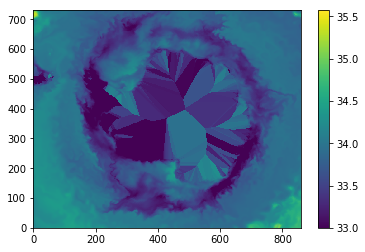

In [59]:
import matplotlib.pyplot as plt
plt.close()
plt.pcolormesh(salt_it[11])
plt.colorbar()
plt.show()

In [60]:
#set up surface net heat flux sensitivity to SST with dQdSST = -40 in takeshi melt season (Nov till Feb)
dQdSST=np.ones(np.shape(salt_it))*-40
dQdSST[:,zice<0.0]=0.0
dQdSST[:,mask_rho==0]=0.0
dQdSST[2:-2,lat_roms<=-55]=0.0

In [61]:
#set up surface net heat flux sensitivity to SST with dQdSST = -40 in takeshi melt season (Nov till Feb)
dQdSST=np.ones(np.shape(salt_it))*-40
dQdSST[:,zice<0.0]=0.0
dQdSST[:,mask_rho==0]=0.0
dQdSST[2:-2,lat_roms<=-55]=0.0

time_start = 365/12*0.5
time_step = 365/12
time = np.arange(time_start,365,time_step)

# Set up output file
num_lon = size(lon_roms, 1)
num_lat = size(lon_roms, 0)

print('Setting up ' + out_file)
out_id = Dataset(out_file, 'w')
out_id.createDimension('xi_rho', num_lon)
out_id.createDimension('eta_rho', num_lat)
out_id.createDimension('sss_time', len(time))
out_id.createVariable('sss_time', 'f8', ('sss_time'))
out_id.createDimension('sst_time', len(time))
out_id.createVariable('sst_time', 'f8', ('sst_time'))
out_id.variables['sss_time'].long_name = 'time since initialization'
out_id.variables['sss_time'].units = 'days'
out_id.variables['sss_time'].cycle_length = 365.
out_id.variables['sst_time'].long_name = 'time since initialization'
out_id.variables['sst_time'].units = 'days'
out_id.variables['sst_time'].cycle_length = 365.
out_id.createVariable('SSS', 'f8', ('sss_time', 'eta_rho', 'xi_rho'))
out_id.variables['SSS'].long_name = 'surface salinity'
out_id.variables['SSS'].units = 'PSU'
out_id.createVariable('SST', 'f8', ('sst_time', 'eta_rho', 'xi_rho'))
out_id.variables['SST'].long_name = 'surface temperature'
out_id.variables['SST'].units = 'degree Celsius'
out_id.createVariable('dQdSST', 'f8', ('sst_time', 'eta_rho', 'xi_rho'))
out_id.variables['dQdSST'].long_name = 'surface net heat flux sensitivity to SST'
out_id.variables['dQdSST'].units = 'watt meter-2 Celsius-1'

out_id.variables['sss_time'][:] = time  
out_id.variables['sst_time'][:] = time        
out_id.variables['SSS'][:] = salt_it
out_id.variables['SST'][:] = theta_it
out_id.variables['dQdSST'][:] = dQdSST

out_id.close()

In [62]:
# Set up output file
num_lon = size(lon_roms, 1)
num_lat = size(lon_roms, 0)

print('Setting up ' + out_file)
out_id = Dataset(out_file, 'w')
out_id.createDimension('xi_rho', num_lon)
out_id.createDimension('eta_rho', num_lat)
out_id.createDimension('sss_time', len(time))
out_id.createVariable('sss_time', 'f8', ('sss_time'))
out_id.createDimension('sst_time', len(time))
out_id.createVariable('sst_time', 'f8', ('sst_time'))
out_id.variables['sss_time'].long_name = 'time since initialization'
out_id.variables['sss_time'].units = 'days'
out_id.variables['sss_time'].cycle_length = 365.
out_id.variables['sst_time'].long_name = 'time since initialization'
out_id.variables['sst_time'].units = 'days'
out_id.variables['sst_time'].cycle_length = 365.
out_id.createVariable('SSS', 'f8', ('sss_time', 'eta_rho', 'xi_rho'))
out_id.variables['SSS'].long_name = 'surface salinity'
out_id.variables['SSS'].units = 'PSU'
out_id.createVariable('SST', 'f8', ('sst_time', 'eta_rho', 'xi_rho'))
out_id.variables['SST'].long_name = 'surface temperature'
out_id.variables['SST'].units = 'degree Celsius'
out_id.createVariable('dQdSST', 'f8', ('sst_time', 'eta_rho', 'xi_rho'))
out_id.variables['dQdSST'].long_name = 'surface net heat flux sensitivity to SST'
out_id.variables['dQdSST'].units = 'watt meter-2 Celsius-1'

out_id.variables['sss_time'][:] = time  
out_id.variables['sst_time'][:] = time        
out_id.variables['SSS'][:] = salt_it
out_id.variables['SST'][:] = theta_it
out_id.variables['dQdSST'][:] = dQdSST

out_id.close()

Setting up /home/ubuntu/bigStick/tidal_melting/data/preprocessing/processed/waom10_nudge.nc
